<div id="image">
<img src="https://www.peppercube.net/sites/default/files/IMT_02_0.png" WIDTH=800 HEIGHT=400>
</div>
<div id="subject">
<CENTER>
</br>
<font size="5"></br> UE Deep Learning - Projet Final</font></br></div>
</CENTER>
<CENTER>
</br>
<font size="5"></br> Traffic Sign Recognition</font></br></div>
</CENTER>
<CENTER>
<font size="3"></br>June 5, 2019</font></br></div>
</CENTER>
<CENTER>
<span style="color:blue">federico.llanes@imt-atlantique.net</span>
</CENTER>
<CENTER>
</div>

**The German Traffic Sign Benchmark is a multi-class, single-image classification challenge with,**
    
   * 144,769 labelled traffic sign images of 2,416 traffic sign instances in 70 classes.
   
**The GTSRB dataset criteria:**

* Discard tracks with less than 30 images.

* Discard classes with less than 9 tracks.

* For the remaining tracks: If the track contains more than 30 images, equidistantly sample 30 images.

**The selection procedure reduced the number to 51,840 images and 43 classes**

The dataset can be downloaded from https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html 

## Importing the relevant packages

In [2]:
import numpy as np
import tensorflow as tf
from skimage import io
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Conv2D,MaxPooling2D

from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils,plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from IPython.display import Image

from matplotlib import pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix
import itertools


%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

#### THE FOLLOWING CODE IS TO RUN THE MODEL ON GOOGLE COLLABS. NOT NECCESSARY IF  RUN LOCALLY

In [117]:
#This code is for google colab.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This code is ran on google colab, the images were preprocessed locally and then exported to drive for a faster perfomance, since it takes a very long time to pre process on the cloud
#Although the training is much faster.
y_train = np.load('/content/drive/My Drive/Colab Notebooks/y_train.npy')
X_test = np.load('/content/drive/My Drive/Colab Notebooks/X_test.npy')
y_test = np.load('/content/drive/My Drive/Colab Notebooks/y_test.npy')
X_train = np.load('/content/drive/My Drive/Colab Notebooks/X_train.npy')
Y = np.load('/content/drive/My Drive/Colab Notebooks/Y.npy')


## Preprocessing of the images

* The original images were taken by a on board camera in a car, and then cropped through a software.

* Each image contains at least 5 pixels marginand range from 50x50 to 222x193 pixels

This means we can crop 2 pixels out of each side.


In [ ]:
def image_transformation(img):
    img = img[2:-2,2:-2,:]
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.rollaxis(img,-1) #We need to roll the axis to feed to the neuronal net.
    return img

## Preprocess all training images into a numpy array

Preprocess of all the training images into numpy arrays and the labels of images from paths.

In [ ]:
import glob
training_images_path = glob.glob('images/training/*/*.ppm') #The folder were our training images are located.
X_train = []
y_train = []
np.random.shuffle(training_images_path) #We shuffle it.
for img_path in training_images_path:
    try:
        img = image_transformation(io.imread(img_path)) #We transform the image.
            #label = get_class(img_path)
        X_train.append(img)
        y_train.append(int(img_path.split('/')[-2])) #The label is the name of the folder.
        if len(imgs)%1000 == 0: 
            print("Processed {} percent".format(len(y_train)/len(all_img_paths)))
    except:
        pass
print("Processed 100 percent")

In [ ]:
test = pd.read_csv('GT-final_test.csv',sep=';') #On the csv it's the name of the files and the label.
X_test = []
y_test = []
for _,element in test.iterrows(): #For each element on our dataframe.
    img_path = os.path.join('images/test/',element["Filename"]) #We get the name of the file
    X_test.append(image_transformation(io.imread(img_path))) #We transform the image and append it
    y_test.append(element["ClassId"]) #We get the classid and append it as well.
    if len(y_test)%1000 == 0: 
        print("Processed {} percent".format(len(y_test)/len(test)))
print("Processed 100 percent")
X_train = np.array(X_train, dtype='float32') #We convert it to a np array
Y = np.eye(NUM_CLASSES, dtype='uint8')[y_train] #To feed it to the CNN.
y_train = np.array(y_train) 

Processed 0.0791765637371338 percent
Processed 0.1583531274742676 percent
Processed 0.2375296912114014 percent
Processed 0.3167062549485352 percent
Processed 0.39588281868566905 percent
Processed 0.4750593824228028 percent
Processed 0.5542359461599367 percent
Processed 0.6334125098970704 percent
Processed 0.7125890736342043 percent
Processed 0.7917656373713381 percent
Processed 0.8709422011084719 percent
Processed 0.9501187648456056 percent


## Set of the class names list as a tuple with number and description correspondingly.

In [23]:
class_names = {0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)',2:'Speed limit (50km/h)',3:'Speed limit (60km/h)',
 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',6:'End of speed limit (80km/h)',7:'Speed limit (100km/h)',
 8:'Speed limit (120km/h)',9:'No passing',10:'No passing for vehicles over 3.5 metric tons',11:'Right-of-way at the next intersection',
12:'Priority road',13:'Yield',14:'Stop',15:'No vehicles',
16:'Vehicles over 3.5 metric tons prohibited',17:'No entry',18:'General caution',19:'Dangerous curve to the left',  
20:'Dangerous curve to the right',    21:'Double curve', 22:'Bumpy road',  23:'Slippery road',  
24:'Road narrows on the right',25:'Road work',26:'Traffic signals',  27:'Pedestrians', 
28:'Children crossing',29:'Bicycles crossing',30:'Beware of ice/snow',31:'Wild animals crossing',
32:'End of all speed and passing limits',33:'Turn right ahead',34:'Turn left ahead',35:'Ahead only',
36:'Go straight or right',37:'Go straight or left',38:'Keep right',39:'Keep left',
40:'Roundabout mandatory',41:'End of no passing',42:'End of passing by vehicles over 3.5 metric tons'}

## Histogram about the number of ocurrences vs. class number. 

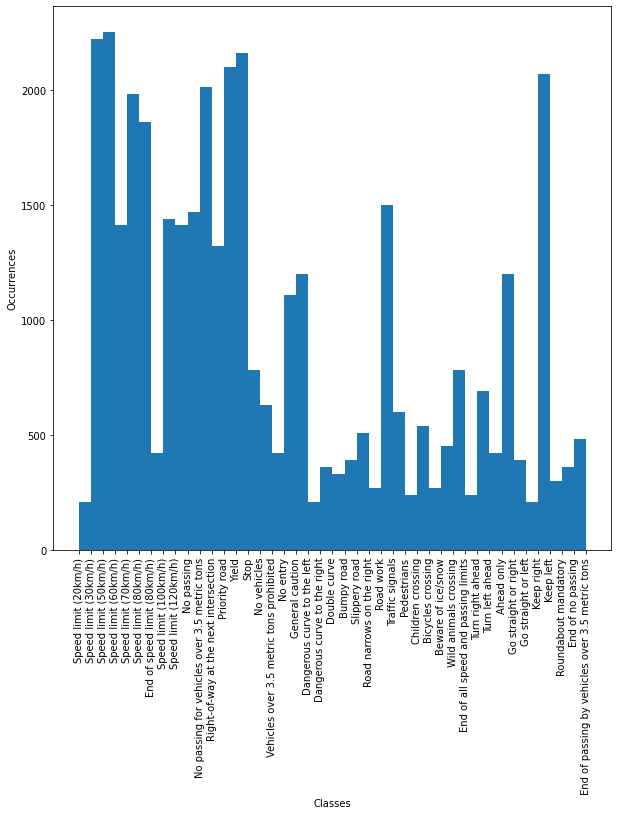

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
bins=np.linspace(0,42,43)
plt.hist(y_train,bins)
ax.set_xticklabels(class_names.values(), rotation=90)
plt.xticks(ticks=bins)
plt.xlabel('Classes')
plt.ylabel('Occurrences')
plt.show()

There's definitely a class imbalance, as some classes are much more likely to occur than others.

## Quantity each traffic sign recognition in the GTSRB

In [25]:
from collections import Counter
count = Counter(y_train)
for i in range(43):
    print(f'{class_names[i]:50}',"==>",count[i])

Speed limit (20km/h)                               ==> 210
Speed limit (30km/h)                               ==> 2220
Speed limit (50km/h)                               ==> 2250
Speed limit (60km/h)                               ==> 1410
Speed limit (70km/h)                               ==> 1980
Speed limit (80km/h)                               ==> 1860
End of speed limit (80km/h)                        ==> 420
Speed limit (100km/h)                              ==> 1440
Speed limit (120km/h)                              ==> 1410
No passing                                         ==> 1470
No passing for vehicles over 3.5 metric tons       ==> 2010
Right-of-way at the next intersection              ==> 1320
Priority road                                      ==> 2100
Yield                                              ==> 2160
Stop                                               ==> 780
No vehicles                                        ==> 630
Vehicles over 3.5 metric tons prohibited    

While speed limit 30km/h as over 2000 occurences, the 20km/h only has 200. Meaning it would be easy for the AI to simply guess it's 30km/h. This is something we'll have to pay attention to, to see if there's anything weird going on. We'll find out after training

## Traffic signs after preprocessing

In the next set of images, it's possible to see the correctly classifying of each traffic sign and the quantity after the pre-processing of each image.

In [26]:
def split_text(txt): #A small function I wrote to make sure the text is never too large
    if len(txt) > 20:
        txt = list(txt)
        for i in range(20):
            if txt[20-i] == " ":
                txt[20-i] = "\n"
                return "".join(txt)
    return txt

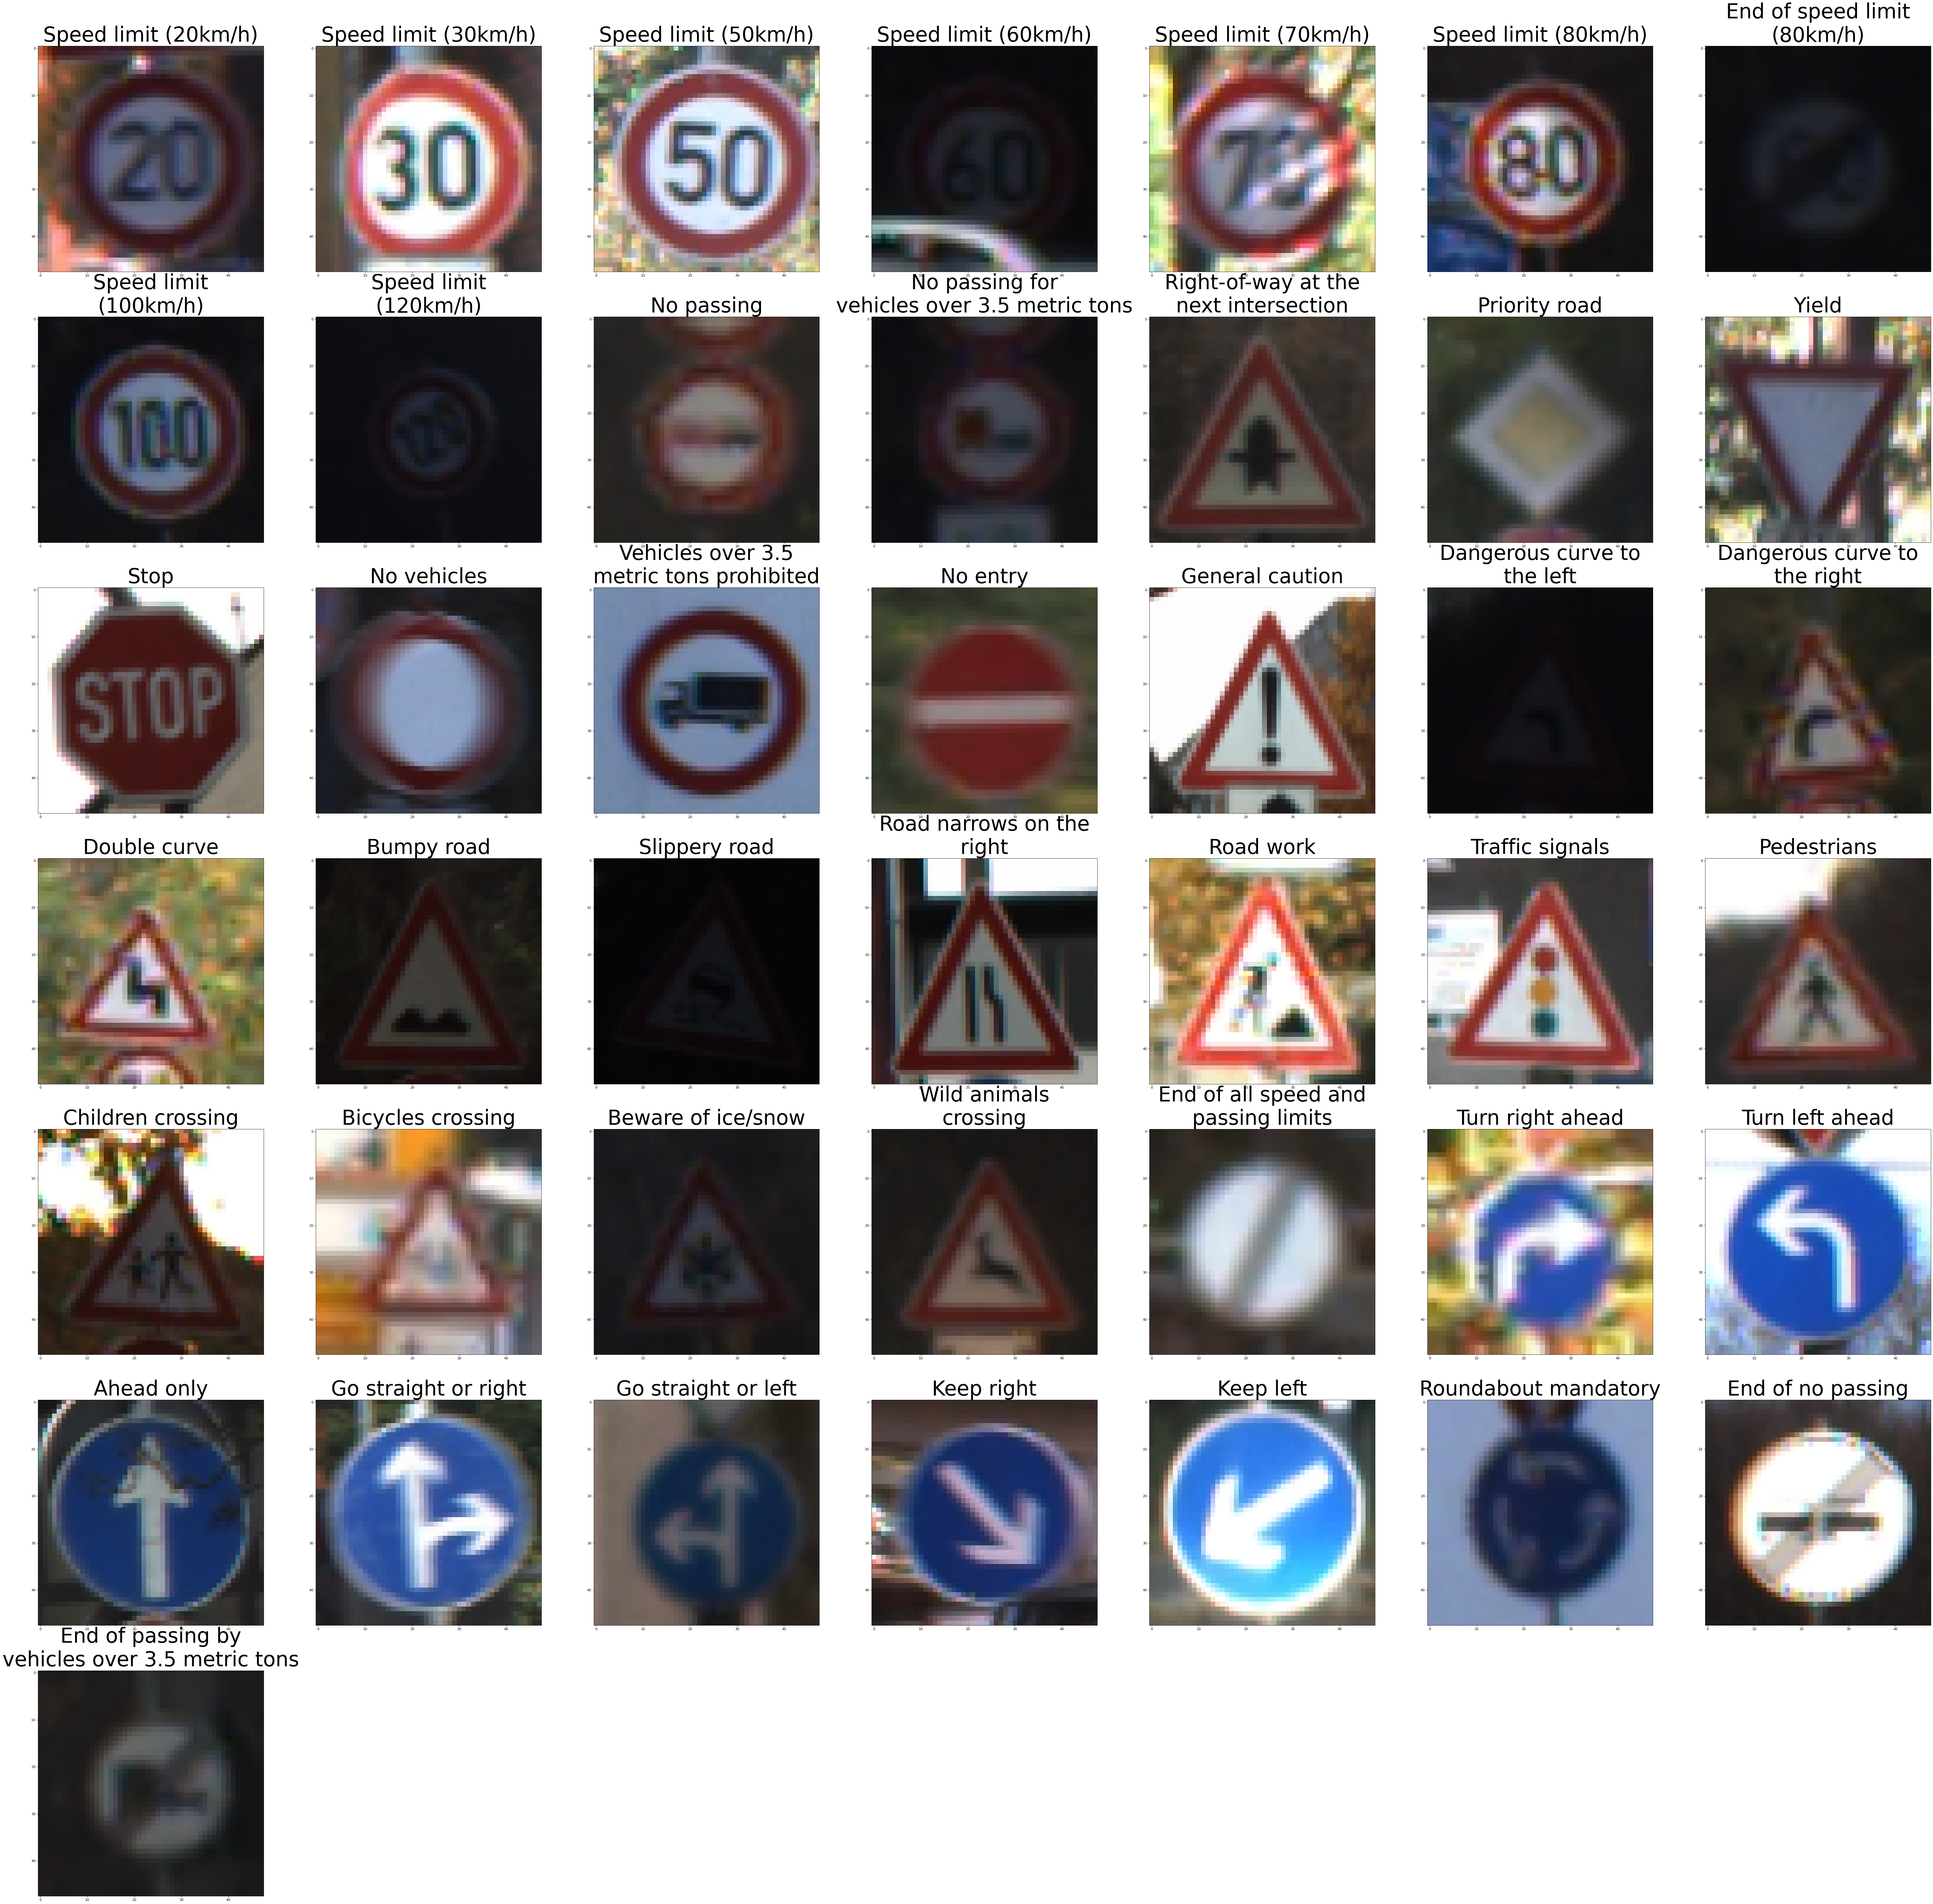

In [28]:
plt.figure(figsize=(100, 100), dpi= 80, facecolor='w', edgecolor='k')
for i in range(43):
    plt.subplot(7, 7, i + 1) 
    plt.imshow(np.rollaxis(np.rollaxis(X_test[np.where(y_test == i)[0][0]], 2), 2)) #We have to unroll the axis, which makes the code look complicated.
    #But basically we are finding the first instance of each type, and then unrolling the axis to show the image.
    plt.title(split_text(class_names[i]),fontsize=60)
plt.show()

# Implementation of the Keras Model

Based on the  8-layer DNN architecture showed in the paper, **"Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition"**, as you can see in the next figure.


* Aadded three **Convolutional Layer** in each convolutional-max pooling layers defined above and the **Dropout Layer** after every **Max Pooling Layer**.

* I used **ReLu** activation except for the output layer, because in the last one we wanted to show the probability for each class, so we used the **softmax activation**.



In [77]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(3, IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model



## Configuration and Compilation of the Model

Before training the model, we need to configure the model the learning algorithm and compile it.

* **loss (lr)**: Loss function we want to optimize. We cannot use error percentage as it is not continuous and thus non differentiable. We therefore use a proxy for it: categorical_crossentropy

* **optimizer** : We use standard stochastic gradient descent with Nesterov momentum.

* **metric** : Since we are dealing with a classification problem, our metric is accuracy.


In [78]:
model = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

## Summary of the Model

With this command we print a summary representation of our sequential model.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 40, 40)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 38, 38)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 19, 19)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 19, 19)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 19, 19)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 17, 17)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 8, 8)          0

# Visualization of the model

With Keras we used the utility function **plot_model** to visualize the Keras model with the number of images in the data set and each type of layer. Also we used the argument **show_shapes** to show the input array and the output array.

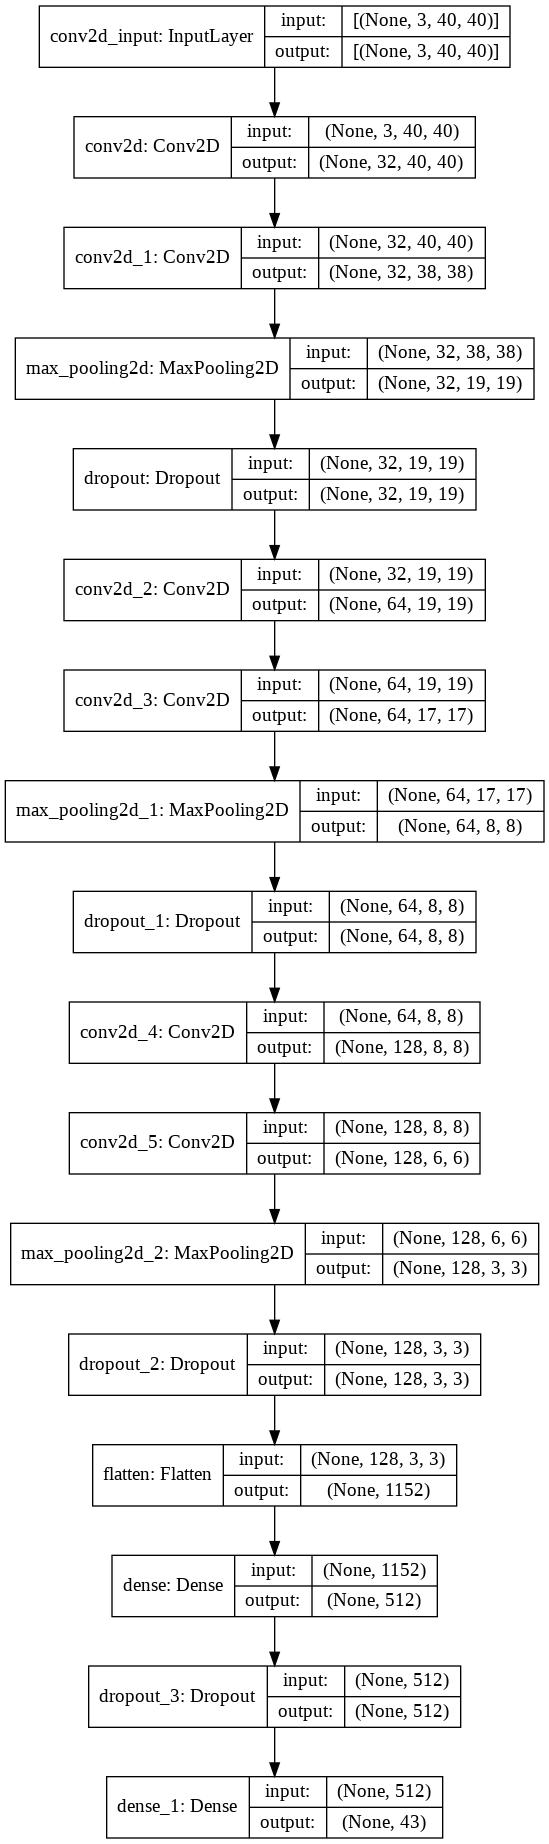

In [ ]:
plot_model(model, show_shapes=True, to_file="sample3.jpg")
Image(retina=True, filename='sample3.jpg')

# Training

In our our model we are going to iterate over batches of training set, each of size batch_size. For each batch, gradients will be computed and updates will be made to the weights of the network automatically. One iteration over all the training set is referred to as an epoch. Training is usually run until the loss converges to a constant.

We will add a couple of features to our training:

   * Learning rate scheduler : Decaying learning rate over the epochs usually helps model learn better
   
   * Model checkpoint : We will save the model with best validation accuracy. This is useful because our network might start overfitting after a certain number of epochs, but we want the best model.

These can improve the model accuracy and the features are implemented via callback feature of Keras. **Callback** are a set of functions that will applied at given stages of training procedure like end of an epoch of training. Were, Keras provides inbuilt functions for both learning rate scheduling and model checkpointing.

In [79]:
batch_size = 32
nb_epoch = 20 
history=model.fit(X_train, Y,
          batch_size=batch_size,
          epochs=nb_epoch,
          validation_split=0.2,
          shuffle=True,
          callbacks=[LearningRateScheduler(lr_schedule),
                    ModelCheckpoint('model.h5',save_best_only=True)]
            )

Epoch 1/20
981/981 [==============================] - 20s 20ms/step - loss: 2.8732 - accuracy: 0.2155 - val_loss: 0.3102 - val_accuracy: 0.9105
Epoch 2/20
981/981 [==============================] - 19s 20ms/step - loss: 0.3556 - accuracy: 0.8897 - val_loss: 0.0718 - val_accuracy: 0.9786
Epoch 3/20
981/981 [==============================] - 19s 20ms/step - loss: 0.1400 - accuracy: 0.9563 - val_loss: 0.0428 - val_accuracy: 0.9895
Epoch 4/20
981/981 [==============================] - 19s 19ms/step - loss: 0.0815 - accuracy: 0.9750 - val_loss: 0.0286 - val_accuracy: 0.9923
Epoch 5/20
981/981 [==============================] - 19s 20ms/step - loss: 0.0639 - accuracy: 0.9813 - val_loss: 0.0306 - val_accuracy: 0.9917
Epoch 6/20
981/981 [==============================] - 19s 20ms/step - loss: 0.0509 - accuracy: 0.9838 - val_loss: 0.0243 - val_accuracy: 0.9940
Epoch 7/20
981/981 [==============================] - 19s 20ms/step - loss: 0.0380 - accuracy: 0.9882 - val_loss: 0.0247 - val_accuracy:

# Accuracy of the Data Set

The graph represents a versus between the **probability** and the **epochs** of the **Accuracy** (acc) and the **Value Accuracy** (val_acc) were,

* **acc**, is the accuracy of a batch of training data.

* **val_acc**, is the accuracy of a batch of testing data. 

As you can see, the transition of the **val_acc** label it's quicker than the **acc** label. After ten epochs approximately both of them went stable with probability one.

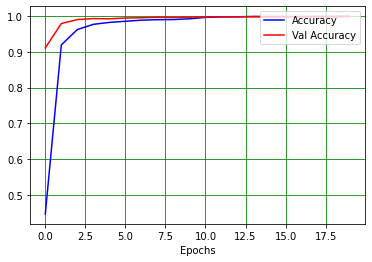

In [81]:
plt.figure(1)
plt.plot(history.history['accuracy'],"b",label="Accuracy") 
plt.plot(history.history['val_accuracy'],"r",label="Val Accuracy") 
plt.legend(loc='upper right')
plt.grid(color='g',linestyle='-')
plt.xlabel('Epochs')
plt.show()


## Loss Function

The graph represents a versus between the **loss rate** and the **epochs** of the **Loss** and the **Value Loss** (val_loss) were,

* **loss** is the value of cost function for your training data.

* **val_loss** is the value of cost function for our cross-validation data. 

As you can observe, the **Val Loss** label decays more rapidly than the **Loss** label with an exponential behavior in the transition zone.  After 10 epochs they converge

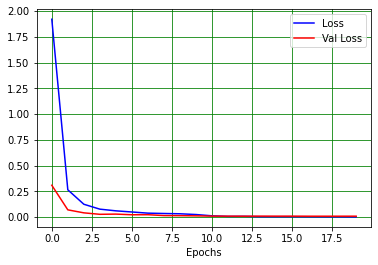

In [82]:
plt.figure(1)
plt.plot(history.history['loss'],"b",label="Loss") 
plt.plot(history.history['val_loss'],"r",label="Val Loss") 
plt.legend(loc='upper right')
plt.grid(color='g',linestyle='-')
plt.xlabel('Epochs')
plt.show()

# Evaluation of the Data

In this section we are going to load the **test data** and then evaluate it. 

In [80]:
y_pred = model.predict_classes(X_test) #The predicted labels

acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Test accuracy = 0.9833729216152018


The accuracy is 98.33 % which is pretty good, and better than a lot of other solutions on kaggle. Overall I've tried many models, all with similar accuracy, but even more complex models failed to perform better than this one.

## Mismatches of the Data Set





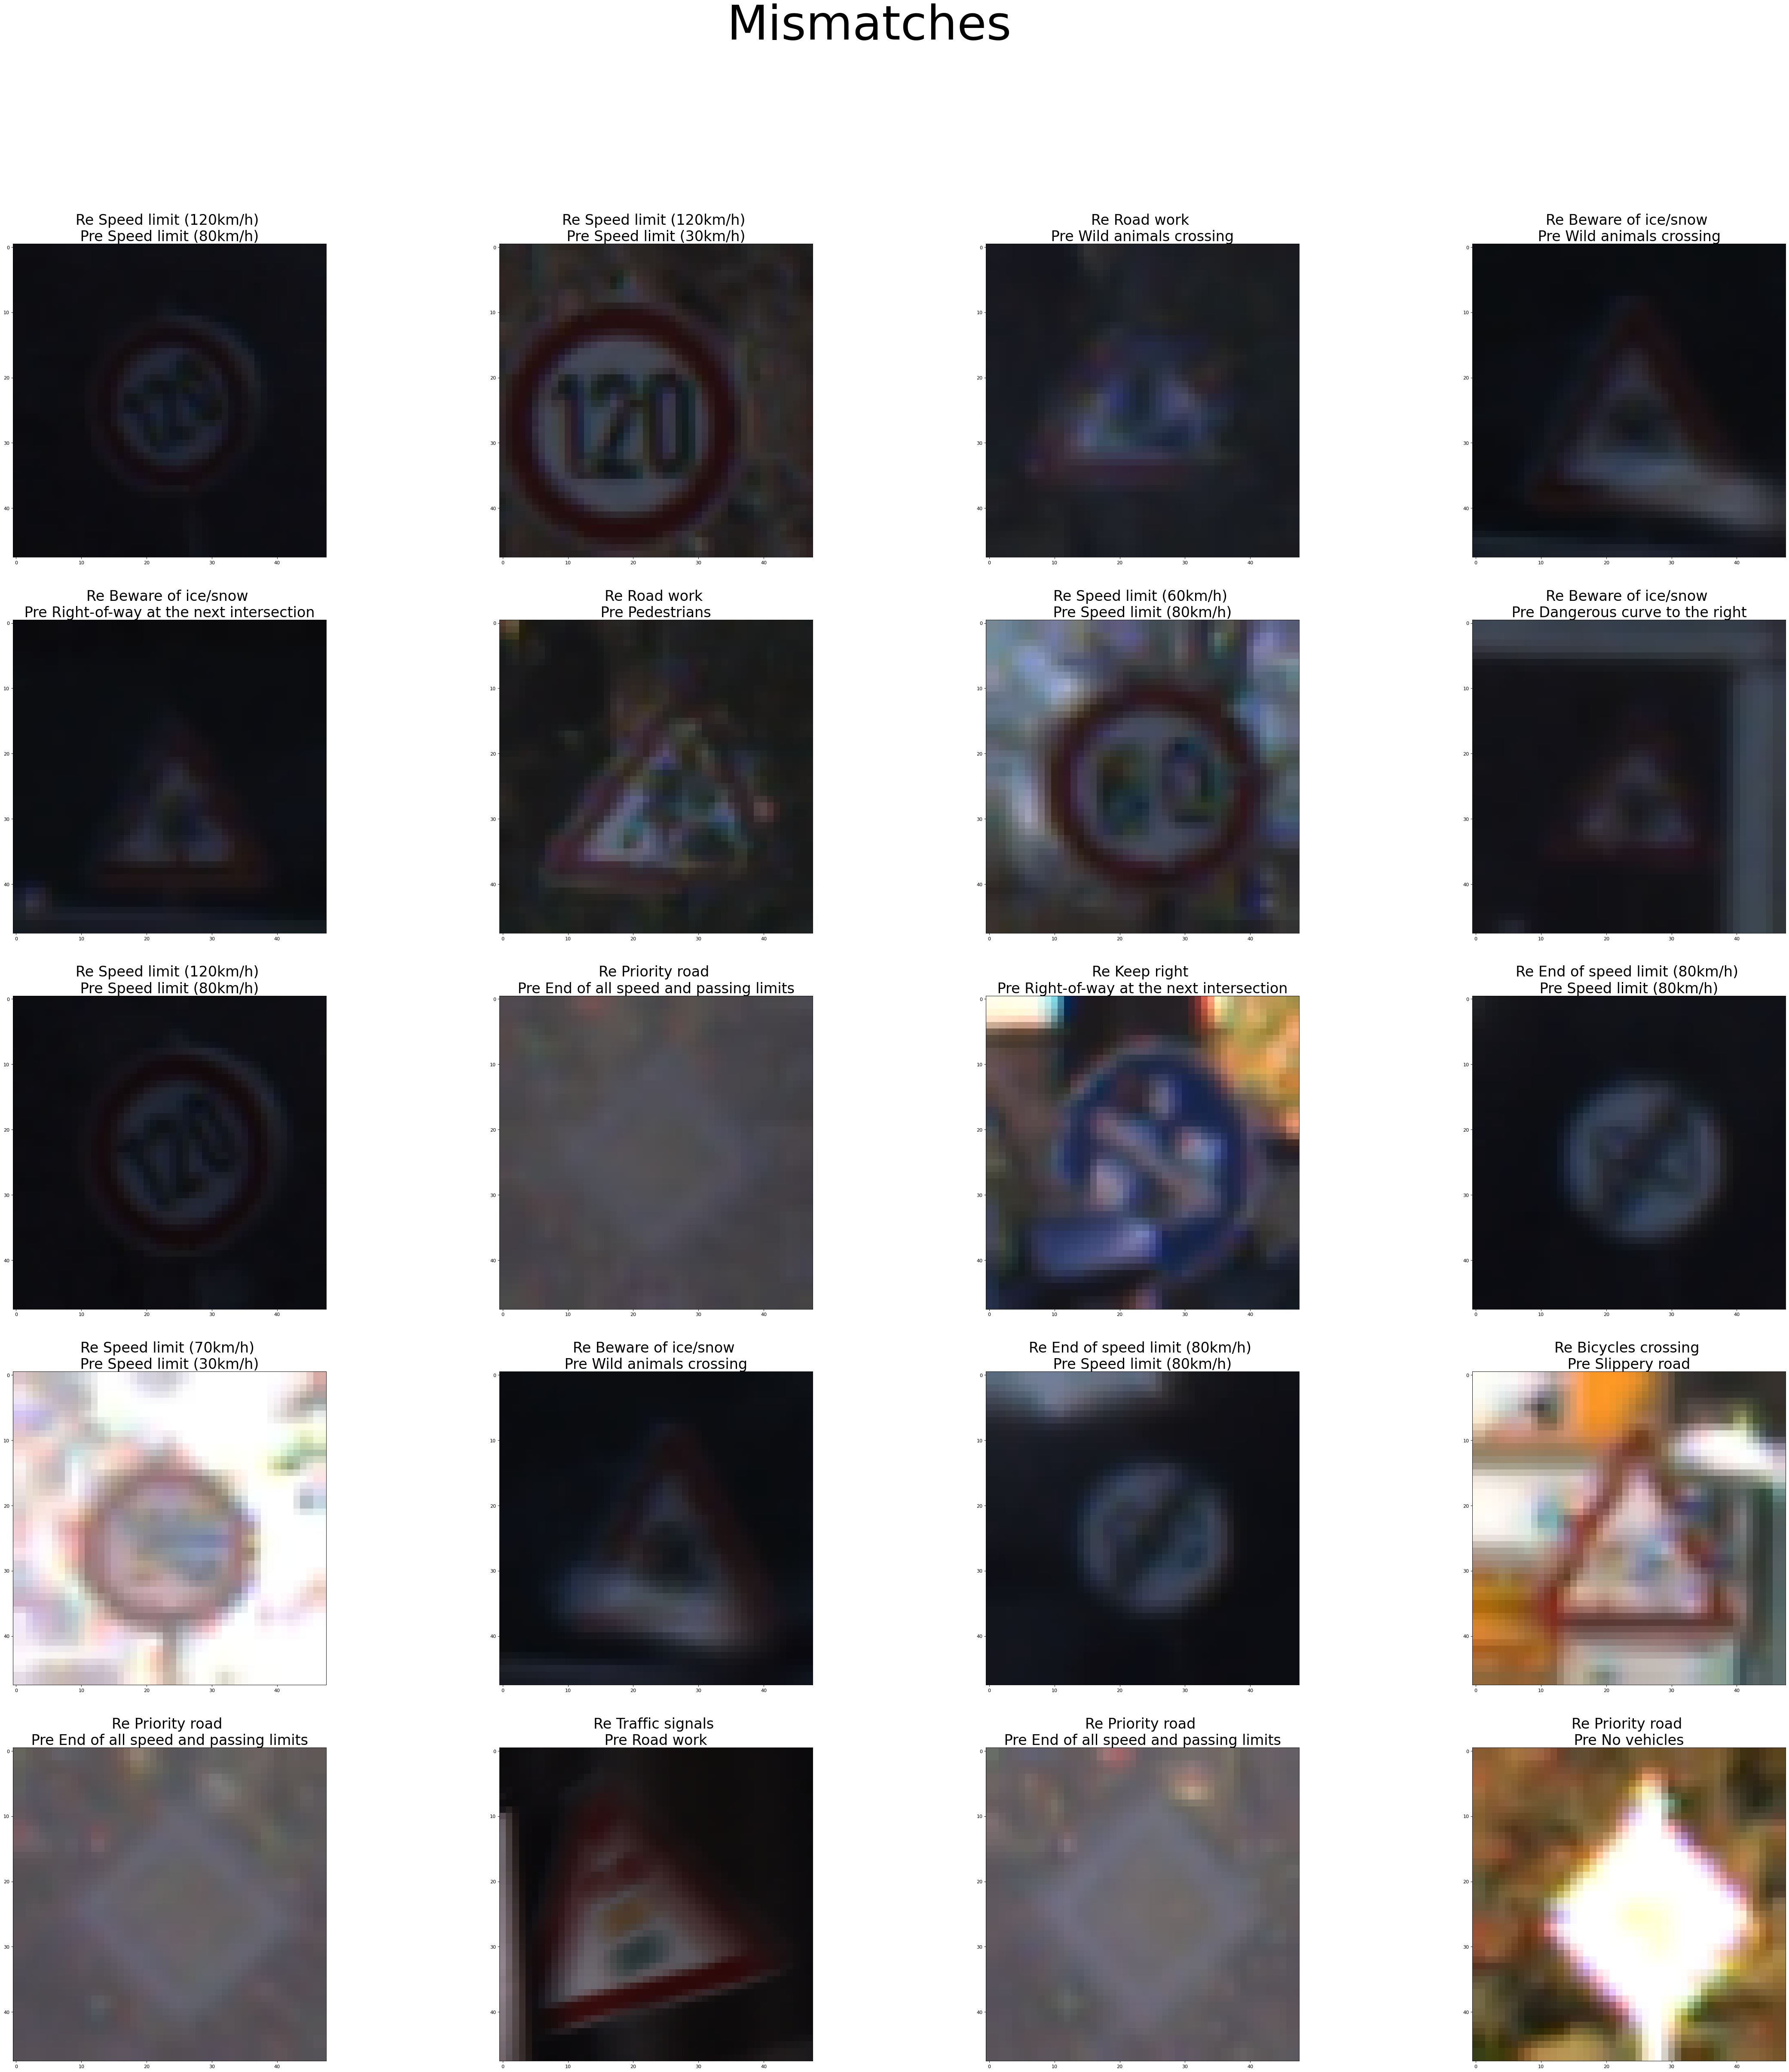

In [116]:
incorrect = np.nonzero(y_pred != y_test)[0] #If the predicted class is different than the real class, then
plt.figure(figsize=(70, 70), dpi= 80, facecolor='w', edgecolor='k')
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(np.rollaxis(np.rollaxis(X_test[incorrect[i]], 2), 2)) #We have to unroll the axis, which makes the code look complicated.
    plt.title('Re %s \n Pre %s ' %(class_names[y_test[incorrect[i]]],class_names[y_pred[incorrect[i]]]),fontsize=30)
plt.suptitle("Mismatches",fontsize=100)
plt.show()

### Mismatches tend to be very low quality pictures that would be extremely hard to recognize even for a human, with some exceptions that don't appear as difficult. Some pictures appear to be particularly dark, meaning that increasing its brighteness could increase the accuracy.

# Confusion matrix

In [84]:
#This function  is from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


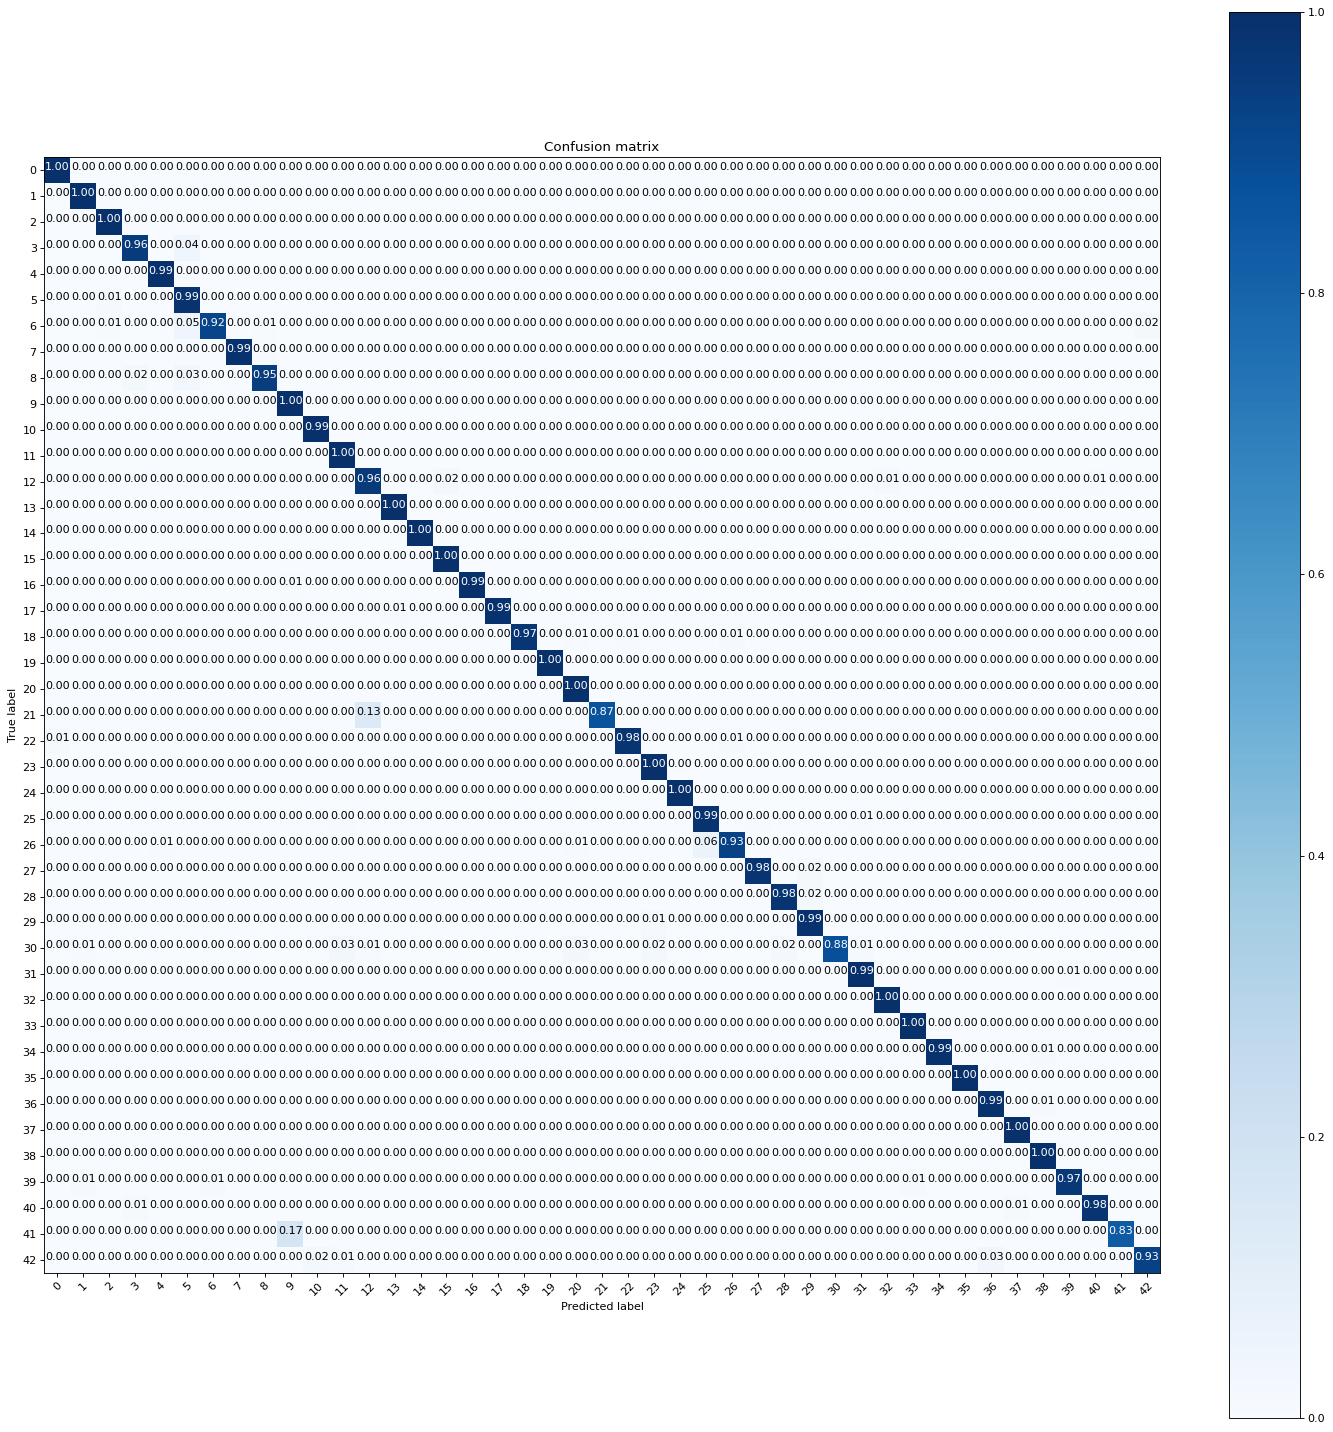

In [121]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred) #We create the confusion matrix, we feed it with the real labels and 
plt.figure(figsize=(18, 18), dpi= 70, facecolor='w', edgecolor='k')
plot_confusion_matrix(cm, class_names,True, title='Confusion matrix',cmap=plt.cm.Blues) #We use the plot function 

From the matrix we can see that classes 41(End of no passing), 30(Beware of ice/snow), and 21(Double curve) are the ones that are doing the worst.

In [122]:
#Another small helper function, this finds all the occurrences of values higher than a sensibility value in the CM, that are OUTSIDE the diagonal
def find_outliers(cm,sensibility):
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  outliers = []
  for i in range(len(cm)):
    for j in range(len(cm)):
      if i != j:
        if cm[i][j] > sensibility:
          outliers.append((i,j))
  return outliers
#Prints the name of the classes that are confused the most often
def print_outliers(outliers):
  if outliers:
    print("The outliers are")
  else:
    print("There are no outliers")
  for element in outliers:
    print("Real: {} ({}), Predicted: {} ({})".format(class_names[element[0]],element[0], class_names[element[1]],element[1] ) )
print_outliers(find_outliers(cm,0.1))

The outliers are
Real: Double curve (21), Predicted: Priority road (12)
Real: End of no passing (41), Predicted: No passing (9)


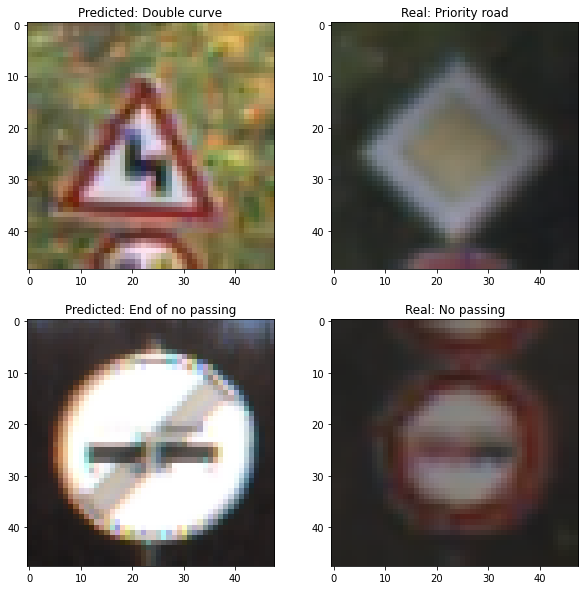

In [124]:
#This graphs the outliers, the pairs that get confused the most. 
def graph_outliers(outliers):
  plt.figure(figsize=(10, 10),facecolor='w', edgecolor='k')
  for i in range(len(outliers)):
    plt.subplot(2, len(outliers), i*2 + 1)
    plt.title("Predicted: {}".format(class_names[outliers[i][0]]))
    plt.imshow(np.rollaxis(np.rollaxis(X_test[np.where(y_test == outliers[i][0])[0][0]], 2), 2))
    plt.subplot(2, len(outliers), i*2 + 2)
    plt.title("Real: {}".format(class_names[outliers[i][1]]))
    plt.imshow(np.rollaxis(np.rollaxis(X_test[np.where(y_test == outliers[i][1])[0][0]], 2), 2))
  plt.show()
graph_outliers(find_outliers(cm,0.1))

It's hard to understand exactly why the CNN confuses the Double curve with the Priority road since they don't seem at all similar, however this does seem to be a common occurence.

We can easily see however why End of no passing and No passing get confused, since they're very similar, specially on the inside.

## Conclusion

The results obtained were satisfactory, the accuracy wasn't bad at all on the never seen dataset, with over 98% of traffic signs being properly recognized (out of 43 classes). While this is impressive, more could be done to improve the quality of the model.

Some ideas include:

* Increasing the luminosity of the pictures using opencv.

* Detecting the contours of each traffic sign, and cropping it off. Making sure they are all position the same way.

